In [1]:
# What's the best way to set LSST pointings on-the-fly
%matplotlib inline
import numpy as np
import lsst.sims.maf.db as db
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.stackers as stackers
import lsst.sims.maf.plots as plots
import lsst.sims.maf.metricBundles as metricBundles
import lsst.sims.maf.utils as utils
import healpy as hp
import matplotlib.pylab as plt

In [2]:
opsdb = db.OpsimDatabase('minion_1016_sqlite.db')
propids, propTags = opsdb.fetchPropInfo()
wfdWhere = utils.createSQLWhere('WFD', propTags)
outDir = 'null'
resultsDb = db.ResultsDb(outDir=outDir)
nside=128

In [6]:
# Let's check in after 2 years
bundleList = []
survey_length = 0.6  # Years
sql = 'filter = "r" and night < %f and ' % (365.25*survey_length) + wfdWhere
metric = metrics.Coaddm5Metric()
slicer = slicers.HealpixSlicer(nside=nside, latCol='ditheredDec', lonCol='ditheredRA')
bundleList.append(metricBundles.MetricBundle(metric, slicer, sql))


Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes


In [7]:
bd = metricBundles.makeBundlesDictFromList(bundleList)
bg = metricBundles.MetricBundleGroup(bd, opsdb, outDir=outDir, resultsDb=resultsDb)
bg.runAll()

Querying database with constraint filter = "r" and night < 219.150000 and propID = 54
Found 3803 visits
Running:  ['opsim_CoaddM5_r_and_night_lt_219_150000_and_propID_54_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


Plotting figures with "filter = "r" and night < 219.150000 and propID = 54" constraint now.
Plotting complete.


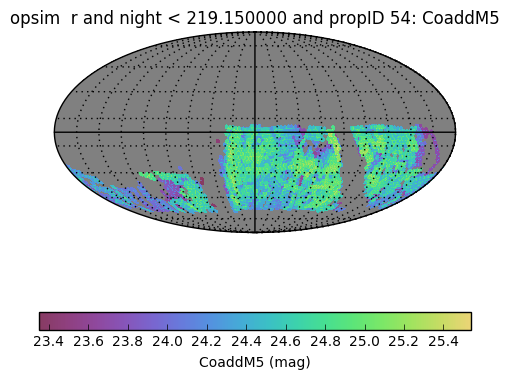

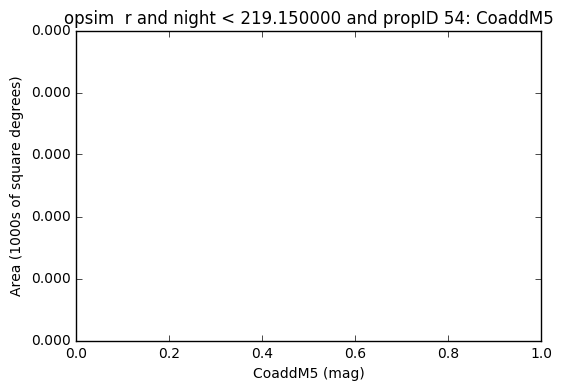

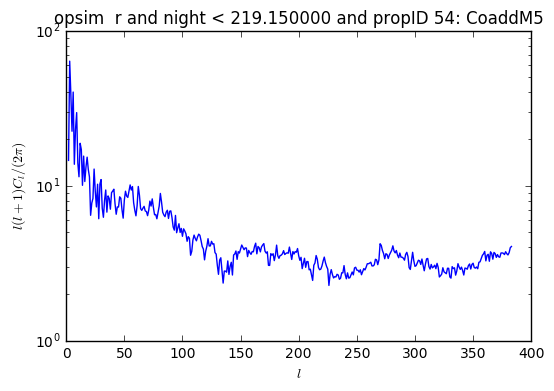

In [8]:
bg.plotAll(closefigs=False)

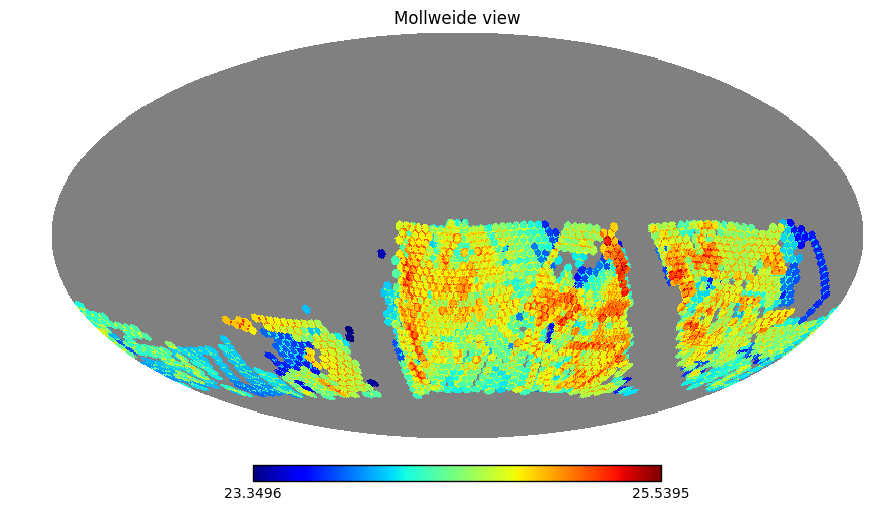

In [9]:
# Zoom in a bit.
hp.mollview(bundleList[0].metricValues)

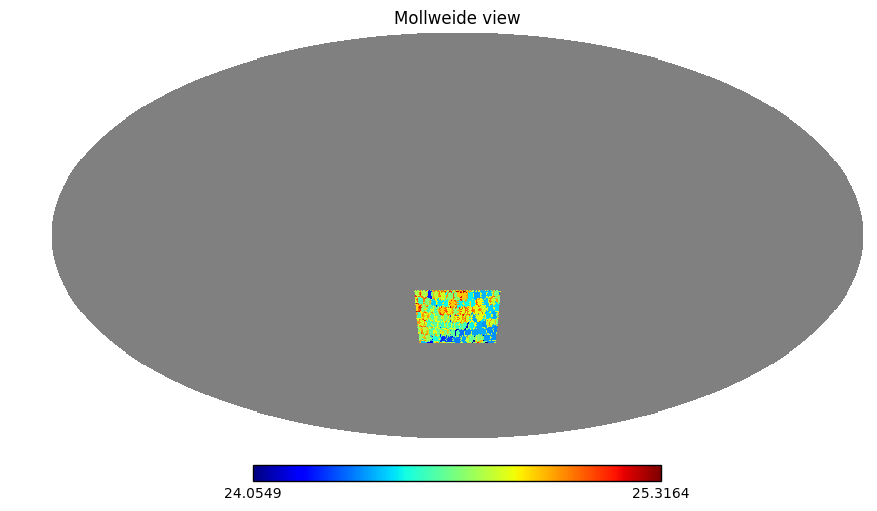

In [11]:
from lsst.sims.utils import hpid2RaDec
ra, dec = hpid2RaDec(nside, np.arange(hp.nside2npix(nside)))
# ok, let's say I want to observe some patch like this
to_observe = bundleList[0].metricValues * 0 + hp.UNSEEN
good = np.where((dec > -40) & (dec < -20) & ((ra < 20) | (ra > 340)))
to_observe[good] = bundleList[0].metricValues[good]
hp.mollview(to_observe, title='Region I want to observe right now.')
                

In [12]:
# Now my question, what's the best way to select pointing positions to:
# 1) cover all those pixels
# 2) Make the map as smooth as possible by strategically placing overlap regions.

# Can I take a smooth grid of pointings near the equator and rotate them to overlap and find the best rotation?
# This feels like cross-correlating things on a sphere--is there some Fourier space/ power spectrum shortcut?

In [28]:
names =['fieldID', 'fieldRA', 'fieldDec']
types = [int, float, float]
fields = np.loadtxt('fieldID.dat', dtype=zip(names,types), delimiter='|', skiprows=1)
good = np.where((fields['fieldDec'] < 30.) & (fields['fieldDec'] > -30))
fields = fields[good]
fields['fieldRA'] = np.radians(fields['fieldRA'])
fields['fieldDec'] = np.radians(fields['fieldDec'])

In [29]:
bl = []
sql=''
metric = metrics.CountMetric(col='fieldDec')
slicer = slicers.HealpixSlicer(nside=nside, latCol='fieldDec', lonCol='fieldRA')
bl.append(metricBundles.MetricBundle(metric, slicer, sql))

Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes


In [30]:
bd = metricBundles.makeBundlesDictFromList(bl)
bg = metricBundles.MetricBundleGroup(bd, None, outDir=outDir, resultsDb=resultsDb)
bg.setCurrent('')
bg.runCurrent('', simData=fields)

Running:  ['opsim_Count_fieldDec_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


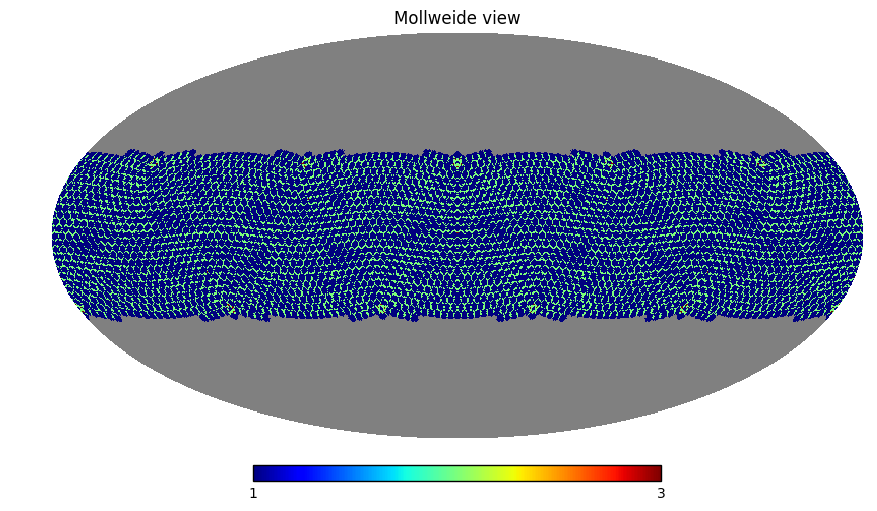

In [51]:
# OK, here's a grid that's not too bad around the equator
hp.mollview(bl[0].metricValues, rot=(0,0,0))

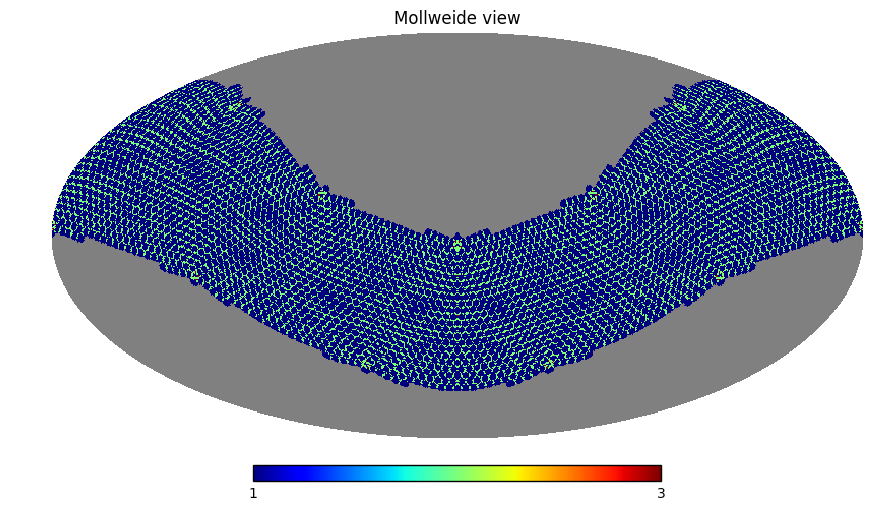

In [57]:
# Note we can rotate this map so that it overlaps our target pixels
rotated_map = hp.mollview(bl[0].metricValues, rot=(0,30,0), return_projected_map=True)

In [53]:
# Now I'd like to find the (arbitrary) rotations that minimize the power spectrum if I multiply the two maps together
# And we need it to be fast since there are 2.5 million observations, so order 100k blocks are going to need to be found
# per simulation


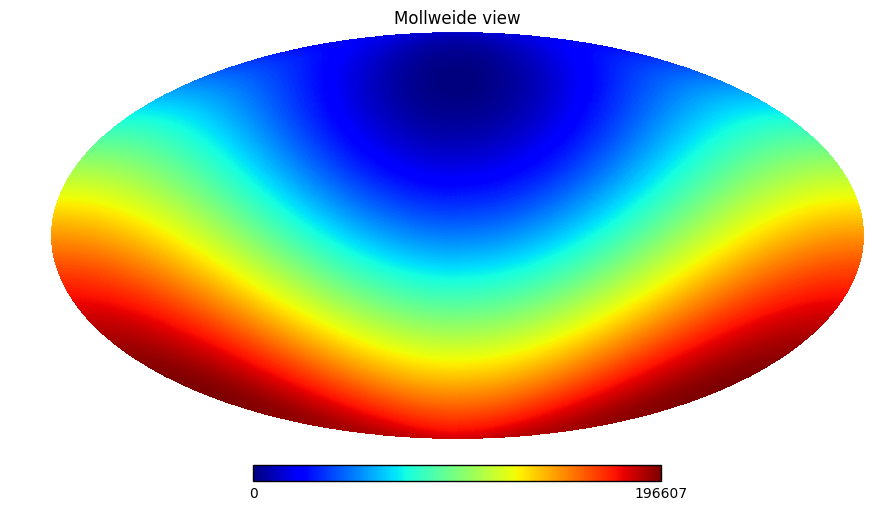

In [78]:
hpids = np.arange(hp.nside2npix(nside))
rotated_ids = hp.mollview(hpids, rot=(0,30,0), return_projected_map=True, xsize=4000)

In [79]:
good = np.where(~np.isinf(rotated_ids))

In [80]:
np.unique(rotated_ids[good]).size, hpids.size

(196608, 196608)

In [81]:
# OK, now I should be able to 

In [82]:
hp.nside2npix(64)

49152